In [2]:
import os
import csv
import json
import numpy as np
from PIL import Image
# import lib.utils as utils
# import lib.features as features

## Get annotations

In [3]:
annotations = json.load(open('/root/data/lice/lice_erko/lice_annotations_0905.json'))
print("{} annotations found".format(len(annotations)))

2020 annotations found


In [4]:
annotations_lice = [a for a in annotations if 'Lice' in a['Label']]
print("{} annotations with lice found".format(len(annotations_lice)))

222 annotations with lice found


In [5]:
annotations = []
for al in annotations_lice:
    image_path = os.path.join('/root/data/lice/lice_erko/', al['Labeled Data'].split('%2F')[-1].split('?')[0])
    im = Image.open(image_path)
    # print(image_path)
    fish_width, fish_height = im.size
    
    for label in al['Label']['Lice']:
        xmin = min([k['x'] for k in label])
        xmax = max([k['x'] for k in label])
    
        ymin = min([k['y'] for k in label])
        ymax = max([k['y'] for k in label])
        
        ymin2 = fish_height-ymax
        ymax2 = fish_height-ymin
        
        annotations.append([image_path, xmin, ymin2, xmax, ymax2, 1])


In [6]:
num_annotations = len(annotations)
print('Total number of lice: {}'.format(num_annotations))

Total number of lice: 417


## Check annotations

In [7]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt

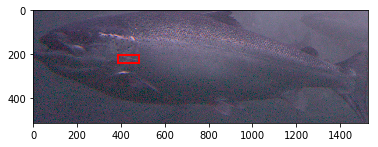

In [8]:
random_lice = annotations[np.random.randint(len(annotations))]
f, ax = plt.subplots(1)
ax.imshow(Image.open(random_lice[0]))
width = random_lice[3] - random_lice[1]
height = random_lice[4] - random_lice[2]
rec = patches.Rectangle((random_lice[1], random_lice[2]), width, height, edgecolor='r', linewidth=2, facecolor='none')
ax.add_patch(rec)

# Create non lice data

In [9]:
from scipy.stats import lognorm

In [10]:
# let's create the same number of points and see
heights = []
widths = []
for an in annotations:
    width = an[3] - an[1]
    height = an[4] - an[2]
    heights.append(height)
    widths.append(width)
    
mean_width = np.mean(widths)
mean_height = np.mean(heights)

std_width = np.std(widths)
std_height = np.std(heights)

print('Mean width: {}'.format(mean_width))
print('Mean height: {}'.format(mean_height)) 

Mean width: 39.4700239808
Mean height: 22.0119904077


In [11]:
# create random non lice data
annotations_with_negatives = []

for an in annotations:
    im = Image.open(an[0])
    fish_width, fish_height = im.size

    random_height = np.random.choice(heights)
    random_width = np.random.choice(widths)
    rx = np.random.randint(0, fish_height - int(random_height) -1 )
    ry = np.random.randint(0, fish_width - int(random_width) -1 )

    annotations_with_negatives.append(an)
    annotations_with_negatives.append([an[0], rx, ry, rx+random_height, ry+random_width, 0])

In [13]:
num_annotations = len(annotations_with_negatives)
print('Total number of data points: {}'.format(num_annotations))

Total number of data points: 834


# Create orb descriptors

In [14]:
from lib import features as features

In [15]:
num_annotations = len(annotations_with_negatives)

chunk_size = 50
num_chunks = num_annotations / chunk_size

half_patch_size = 24

In [16]:
print 'Processing %i annotations' % (num_annotations, )

for chunk_index in range(0, num_chunks + 1):
    start_annotation_index = chunk_index * chunk_size
    end_annotation_index = (chunk_index + 1) * chunk_size
    if end_annotation_index > num_annotations:
        end_annotation_index = num_annotations

    annotations_subset = annotations[start_annotation_index : end_annotation_index]
      
    feature_output = features.get_sealice_orb_descriptors(annotations_subset, half_patch_size, num_annotations)
    
    all_frames_lice_ORB_descr = feature_output['all_frames_lice_ORB_descr']
    all_frames_nonlice_ORB_descr = feature_output['all_frames_nonlice_ORB_descr']

    '''
    all_frames_lice_kps = [item for sublist in all_frames_lice_kps for item in sublist]
    all_frames_nonlice_kps = [item for sublist in all_frames_nonlice_kps for item in sublist]
    all_frames_lice_rgb_patches = [item for sublist in all_frames_lice_rgb_patches for item in sublist]
    all_frames_nonlice_rgb_patches = [item for sublist in all_frames_nonlice_rgb_patches for item in sublist]
    all_frames_lice_rotated_rgb_patches = [item for sublist in all_frames_lice_rotated_rgb_patches for item in sublist]
    all_frames_nonlice_rotated_rgb_patches = [item for sublist in all_frames_nonlice_rotated_rgb_patches for item in sublist]
    all_frames_lice_gray_patches = [item for sublist in all_frames_lice_gray_patches for item in sublist]
    all_frames_nonlice_gray_patches = [item for sublist in all_frames_nonlice_gray_patches for item in sublist]
    all_frames_lice_rotated_gray_patches = [item for sublist in all_frames_lice_rotated_gray_patches for item in sublist]
    all_frames_nonlice_rotated_gray_patches = [item for sublist in all_frames_nonlice_rotated_gray_patches for item in sublist]
    '''

    #all_frames_lice_ORB_descr = [ orb_list if orb_list is not None for orb_list in all_frames_lice_ORB_descr ]
    all_frames_lice_ORB_descr = [ orb for orb_list in all_frames_lice_ORB_descr for orb in orb_list ]
    #all_frames_nonlice_ORB_descr = [ orb_list if orb_list is not None for orb_list in all_frames_nonlice_ORB_descr ]
    all_frames_nonlice_ORB_descr = [ orb for orb_list in all_frames_nonlice_ORB_descr for orb in orb_list ]

    print 'Got %i sealice descriptors, %i non sealice descriptors' % (len(all_frames_lice_ORB_descr), len(all_frames_nonlice_ORB_descr))
    
    '''
    np.save(filename_+'_chunk_'+str(i)+'_startFrame_'+str(start_frame)+'_to_endFrame_'+str(end_frame)+'_lice_kps', all_frames_lice_kps)
    np.save(filename_+'_chunk_'+str(i)+'_startFrame_'+str(start_frame)+'_to_endFrame_'+str(end_frame)+'_nonlice_kps', all_frames_nonlice_kps)
    np.save(filename_+'_chunk_'+str(i)+'_startFrame_'+str(start_frame)+'_to_endFrame_'+str(end_frame)+'_lice_rgb_patches', all_frames_lice_rgb_patches)
    np.save(filename_+'_chunk_'+str(i)+'_startFrame_'+str(start_frame)+'_to_endFrame_'+str(end_frame)+'_nonlice_rgb_patches', all_frames_nonlice_rgb_patches)
    np.save(filename_+'_chunk_'+str(i)+'_startFrame_'+str(start_frame)+'_to_endFrame_'+str(end_frame)+'_lice_rotated_rgb_patches', all_frames_lice_rotated_rgb_patches)
    np.save(filename_+'_chunk_'+str(i)+'_startFrame_'+str(start_frame)+'_to_endFrame_'+str(end_frame)+'_nonlice_rotated_rgb_patches', all_frames_nonlice_rotated_rgb_patches)
    np.save(filename_+'_chunk_'+str(i)+'_startFrame_'+str(start_frame)+'_to_endFrame_'+str(end_frame)+'_lice_gray_patches', all_frames_lice_gray_patches)
    np.save(filename_+'_chunk_'+str(i)+'_startFrame_'+str(start_frame)+'_to_endFrame_'+str(end_frame)+'_nonlice_gray_patches', all_frames_nonlice_gray_patches)
    np.save(filename_+'_chunk_'+str(i)+'_startFrame_'+str(start_frame)+'_to_endFrame_'+str(end_frame)+'_lice_rotated_gray_patches', all_frames_lice_rotated_gray_patches)
    np.save(filename_+'_chunk_'+str(i)+'_startFrame_'+str(start_frame)+'_to_endFrame_'+str(end_frame)+'_nonlice_rotated_gray_patches', all_frames_nonlice_rotated_gray_patches)
    '''

    lice_ORB_descr_out_file = '%s/chunk_%i_lice_ORB_descr' % (output_directory, chunk_index)
    # nonlice_ORB_descr_out_file = '%s/chunk_%i_nonlice_ORB_descr' % (output_directory, chunk_index)

    np.save(lice_ORB_descr_out_file, all_frames_lice_ORB_descr)
    # np.save(nonlice_ORB_descr_out_file, all_frames_nonlice_ORB_descr)
    
print 'Finished processing all annotations'

Processing 834 annotations


AttributeError: 'module' object has no attribute 'ORB_create'

In [ ]:
annotations_file = '/root/data/lice/lice_data_imenco_videos/annotations.csv'

annotations = utils.get_lice_annotations_from_file(annotations_file)
num_annotations = len(annotations)

chunk_size = 50
num_chunks = num_annotations / chunk_size

half_patch_size = 24

output_directory = '/root/bryton/aquabyte_sealice/orb_output'

try: 
    os.makedirs(output_directory)
except OSError:
    if not os.path.isdir(output_directory):
        raise

In [ ]:
annotations_lice[0]